<a href="https://colab.research.google.com/github/treetops81/HR-Research-Project/blob/main/Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next we will look at the diversity profile of the company. This could include a variety of things, but with the data we have we are able to profile the following:
- Gender
- Age
- Ethnicity
- Marital Status
- Citizenship

In [ ]:
# data manipulation
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
import scipy.stats

# useful
from collections import Counter

In [ ]:
df = pd.read_csv(r'https://raw.githubusercontent.com/treetops81/HR-Research-Project/main/HRDataset_v14_Edited.csv', index_col = 0)

In [ ]:
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Remote
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,0,19,Production Technician I,MA,1960,1983-07-10,M,Single,US Citizen,0,White,2011-07-05,NaN,N/A-StillEmployed,Active,Production,Michael Albert,22,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1,0
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,1,27,Sr. DBA,MA,2148,1975-05-05,M,Married,US Citizen,0,White,2015-03-30,2016-06-16,career change,Voluntarily Terminated,IT/IS,Simon Roup,4,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17,0
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,1,20,Production Technician II,MA,1810,1988-09-19,F,Married,US Citizen,0,White,2011-07-05,2012-09-24,hours,Voluntarily Terminated,Production,Kissy Sullivan,20,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3,0
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,0,19,Production Technician I,MA,1886,1988-09-27,F,Married,US Citizen,0,White,2008-01-07,NaN,N/A-StillEmployed,Active,Production,Elijiah Gray,16,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15,0
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,1,19,Production Technician I,MA,2169,1989-09-08,F,Divorced,US Citizen,0,White,2011-07-11,2016-09-06,return to school,Voluntarily Terminated,Production,Webster Butler,39,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2,0


In [ ]:
print(df.DOB.min())
print(df.DOB.max())

1971-07-10
2070-12-22


Looks like our DOB column has an issue where everythin before 1970 has been converted to 20XX rather than 19XX.

In [ ]:
def correct_dobs(date_input):
  if date_input < datetime.date(2000,1,1):
    return date_input
  else:
    return date_input - relativedelta(years = 100)

def employee_age(date_input):
  now = datetime.datetime.now()
  now = now.date()
  age = relativedelta(now, date_input)
  age = age.years
  return age

def age_bands(age_input):
  # Commonly used age ranges
  if age_input < 18:
    return '< 18'
  elif age_input < 25:
    return '18-24'
  elif age_input < 35:
    return '25-34'
  elif age_input < 45:
    return '35-44'
  elif age_input < 55:
    return '45-54'
  elif age_input < 65:
    return '55-64'
  elif age_input > 64:
    return '> 65'

In [ ]:
df['Temp_Dobs'] = pd.to_datetime(df['DOB'], infer_datetime_format=True)
df['Correct_DOBS'] = df.Temp_Dobs.apply(lambda x: correct_dobs(x))
df['Age'] = df.Correct_DOBS.apply(lambda x: employee_age(x))
df['Age_group'] = df.Age.apply(lambda x: age_bands(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


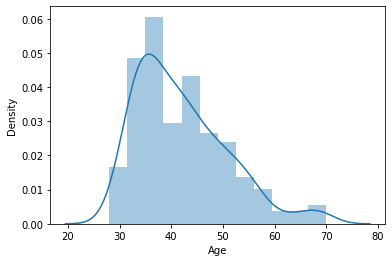

In [ ]:
sns.distplot(df.Age)

Lets start simply, by analysing the company as a whole before breaking into department or management.

In [ ]:
df.HispanicLatino.value_counts()

0    283
1     28
Name: HispanicLatino, dtype: int64

In [ ]:
Gender = [0, 1]
Gender_counts = []
for count, gender in enumerate(Gender):
  Gender_counts.append([])
  Gender_counts[count]= df[df['GenderID'] == gender].shape[0]

Races = df.RaceDesc.unique().tolist()
Races_counts = []
for count, race in enumerate(Races):
  Races_counts.append([])
  Races_counts[count]= df[df['RaceDesc'] == race].shape[0]

Ages = df.Age_group.unique().tolist()
Ages.sort()
Ages_counts = []
for count, age_band in enumerate(Ages):
  Ages_counts.append([])
  Ages_counts[count]= df[df['Age_group'] == age_band].shape[0]

Citizenship = df.CitizenDesc.unique().tolist()
Citizenship_counts = []
for count, citizenship in enumerate(Citizenship):
  Citizenship_counts.append([])
  Citizenship_counts[count]= df[df['CitizenDesc'] == citizenship].shape[0]

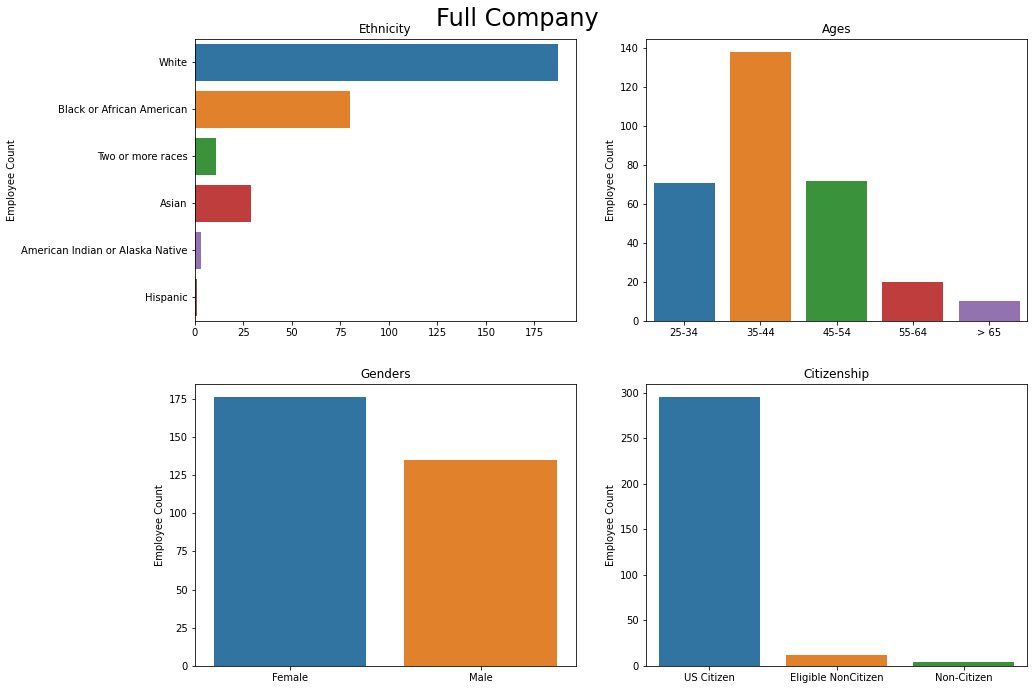

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
figure.suptitle('Full Company', fontsize = 24)

sns.barplot(ax = axes[0,0], y = Races, x = Races_counts)
axes[0,0].set(ylabel = 'Employee Count')
axes[0,0].set_title('Ethnicity')

sns.barplot(ax = axes[1,0], x = ['Female', 'Male'], y = Gender_counts)
axes[1,0].set(ylabel = 'Employee Count')
axes[1,0].set_title('Genders')

sns.barplot(ax = axes[0,1], x = Ages, y = Ages_counts)
axes[0,1].set(ylabel = 'Employee Count')
axes[0,1].set_title('Ages')

sns.barplot(ax = axes[1,1], x = Citizenship, y = Citizenship_counts)
axes[1,1].set(ylabel = 'Employee Count')
axes[1,1].set_title('Citizenship')

figure.tight_layout(pad = 3.0)

We can see from our initial charts that we have:
- A higher % of females to males (56.5% females)
- A heavy skew towards white employees (60%), with the majority of the rest being Black / African American & Asian (25% & 9%) respectively.
- There is a large distribution in ages, with only 23% in the most common band of 25-34. We do however note that the youngest employee is 28.
- Unsuprisngly, the majority of employees are US citizens, with 5% of employees not having US citizenship.

Next we want to look up diversity in management and in various departments.

Manager Name = split into two words and join them in reverse using ',' as a seperator

In [ ]:
df_names = df['Employee_Name'].str.split(',',expand = True)
df_names = df_names.rename(columns={0:'Surname', 1:'FirstName'})
df_names['Surname'] = df_names['Surname'].str.strip()
df_names['FirstName'] = df_names['FirstName'].str.strip()

In [ ]:
df = df.join(df_names, df.index, 'left')

In [ ]:
df['EmployeeName'] = df['FirstName'] + ' ' + df['Surname']

In [ ]:
df.iloc[164,43] = 'Brandon R. LeBlanc'

In [ ]:
Managers_ID = df.ManagerName.unique().tolist()

In [ ]:
def manager_flag(name):
  if name in Managers_ID:
    return 1
  else:
    return 0  

In [ ]:
df['ManagersFlag'] = df['EmployeeName'].apply(lambda x: manager_flag(x))

In [ ]:
df_managers = df[df['ManagersFlag'] == 1]
df_managers.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,Remote,Temp_Dobs,Correct_DOBS,Age,Age_group,Surname,FirstName,EmployeeName,ManagersFlag
42,"Champaigne, Brian",10108,1,1,1,1,3,3,0,110929,0,5,BI Director,MA,2045,1972-02-09,M,Married,US Citizen,0,White,2016-09-06,NaN,N/A-StillEmployed,Active,IT/IS,Jennifer Zamora,5,Indeed,Fully Meets,4.50,5,7,1/15/2019,0,8,0,1972-02-09,1972-02-09,49,45-54,Champaigne,Brian,Brian Champaigne,1
60,"Daneault, Lynn",10099,0,0,0,1,6,3,0,65729,0,21,Sales Manager,VT,5473,1990-04-19,F,Single,US Citizen,0,White,2014-05-05,NaN,N/A-StillEmployed,Active,Sales,Debra Houlihan,15,Indeed,Fully Meets,4.62,4,0,1/24/2019,0,8,1,1990-04-19,1990-04-19,31,25-34,Daneault,Lynn,Lynn Daneault,1
76,"Dougall, Eric",10028,0,0,1,1,3,4,0,138888,0,13,IT Manager - Support,MA,1886,2070-07-09,M,Single,US Citizen,0,Black or African American,2014-01-05,NaN,N/A-StillEmployed,Active,IT/IS,Jennifer Zamora,5,Indeed,Exceeds,4.30,5,5,1/4/2019,0,4,0,2070-07-09,1970-07-09,51,45-54,Dougall,Eric,Eric Dougall,1
78,"Dunn, Amy",10105,0,0,0,1,5,3,0,75188,0,18,Production Manager,MA,1731,1973-11-28,F,Single,US Citizen,0,White,2014-09-18,NaN,N/A-StillEmployed,Active,Production,Janet King,2,Google Search,Fully Meets,4.52,4,0,1/15/2019,0,4,0,1973-11-28,1973-11-28,47,45-54,Dunn,Amy,Amy Dunn,1
118,"Gray, Elijiah",10098,0,2,1,1,5,3,0,62957,0,18,Production Manager,MA,1752,1981-07-11,M,Divorced,US Citizen,0,White,2015-06-02,NaN,N/A-StillEmployed,Active,Production,Janet King,2,Employee Referral,Fully Meets,4.63,3,0,1/4/2019,0,2,0,1981-07-11,1981-07-11,40,35-44,Gray,Elijiah,Elijiah Gray,1


In [ ]:
print('There are:', len(Managers_ID), 'many managers and our dataset contains', df_managers.shape[0], 'of these managers')

There are: 21 many managers and our dataset contains 16 of these managers


In [ ]:
Gender = [0, 1]
Gender_counts = []
for count, gender in enumerate(Gender):
  Gender_counts.append([])
  Gender_counts[count]= df_managers[df_managers['GenderID'] == gender].shape[0]

Races = df_managers.RaceDesc.unique().tolist()
Races_counts = []
for count, race in enumerate(Races):
  Races_counts.append([])
  Races_counts[count]= df_managers[df_managers['RaceDesc'] == race].shape[0]

Ages = df_managers.Age_group.unique().tolist()
Ages.sort()
Ages_counts = []
for count, age_band in enumerate(Ages):
  Ages_counts.append([])
  Ages_counts[count]= df_managers[df_managers['Age_group'] == age_band].shape[0]

Citizenship = df_managers.CitizenDesc.unique().tolist()
Citizenship_counts = []
for count, citizenship in enumerate(Citizenship):
  Citizenship_counts.append([])
  Citizenship_counts[count]= df_managers[df_managers['CitizenDesc'] == citizenship].shape[0]

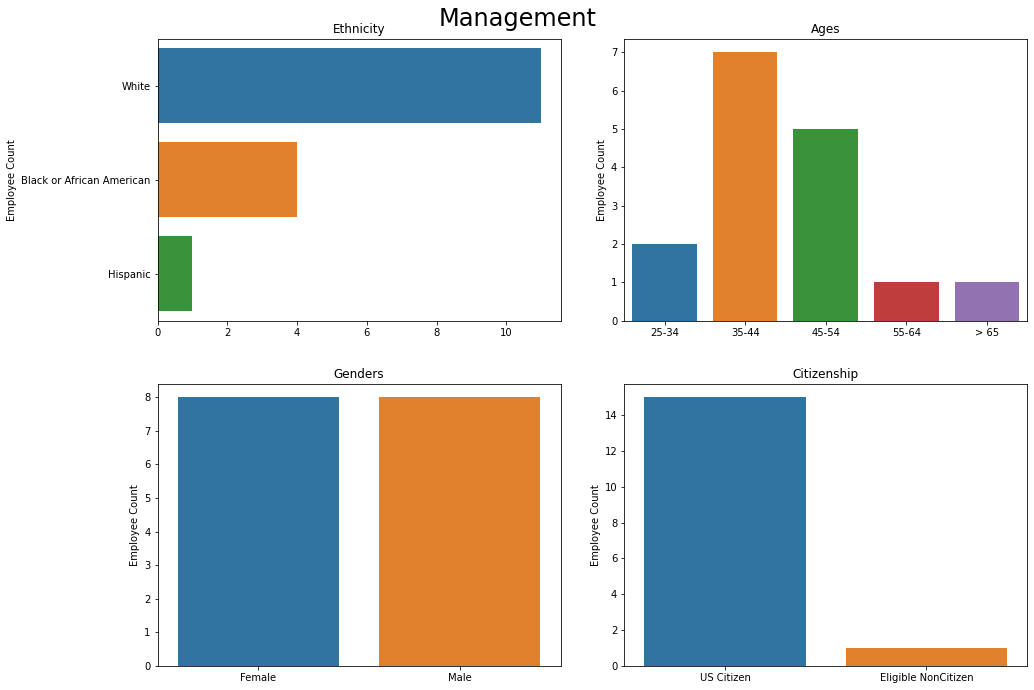

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
figure.suptitle('Management', fontsize = 24)

sns.barplot(ax = axes[0,0], y = Races, x = Races_counts)
axes[0,0].set(ylabel = 'Employee Count')
axes[0,0].set_title('Ethnicity')

sns.barplot(ax = axes[1,0], x = ['Female', 'Male'], y = Gender_counts)
axes[1,0].set(ylabel = 'Employee Count')
axes[1,0].set_title('Genders')

sns.barplot(ax = axes[0,1], x = Ages, y = Ages_counts)
axes[0,1].set(ylabel = 'Employee Count')
axes[0,1].set_title('Ages')

sns.barplot(ax = axes[1,1], x = Citizenship, y = Citizenship_counts)
axes[1,1].set(ylabel = 'Employee Count')
axes[1,1].set_title('Citizenship')

figure.tight_layout(pad = 3.0)

We can see that from our graphs, the general trends for management is the same as the rest of the company.
- Our Gender ratio is now equal, compared to the 56% female skew we saw before.
- We can also see that while 35-44 is the most common age band again, there is a higher percentage of 45-54 and lower percentage of 24-34 colleagues. This is expected as experience is normally a factor in promotions.

In [ ]:
df['']

array(['Production       ', 'IT/IS', 'Software Engineering',
       'Admin Offices', 'Sales', 'Executive Office'], dtype=object)

In [ ]:
df['Department'] = df['Department'].str.strip()
df_production = df[df['Department'] == 'Production']
df_it = df[df['Department'] == 'IT/IS']
df_sales = df[df['Department'] == 'Sales']
df_social = df[df['Department'] == 'Software Engineering']
df_admin = df[df['Department'] == 'Admin Offices']

In [ ]:
df_list = [df_production, df_it, df_sales, df_social, df_admin]
departments = ['Production', 'IT/IS', 'Sales', 'Software Engineering', 'Admin Offices']

0
         Employee_Name  EmpID  ...        EmployeeName  ManagersFlag
0  Adinolfi, Wilson  K  10026  ...  Wilson  K Adinolfi             0
2    Akinkuolie, Sarah  10196  ...    Sarah Akinkuolie             0
3         Alagbe,Trina  10088  ...        Trina Alagbe             0
4     Anderson, Carol   10069  ...      Carol Anderson             0
5    Anderson, Linda    10002  ...      Linda Anderson             0

[5 rows x 45 columns]
1
               Employee_Name  EmpID  ...          EmployeeName  ManagersFlag
1   Ait Sidi, Karthikeyan     10084  ...  Karthikeyan Ait Sidi             0
9         Bacong, Alejandro   10250  ...      Alejandro Bacong             0
12          Barbossa, Hector  10012  ...       Hector Barbossa             0
18             Becker, Renee  10245  ...          Renee Becker             0
25              Booth, Frank  10199  ...           Frank Booth             0

[5 rows x 45 columns]
2
        Employee_Name  EmpID  ...     EmployeeName  ManagersFlag
32   Bu

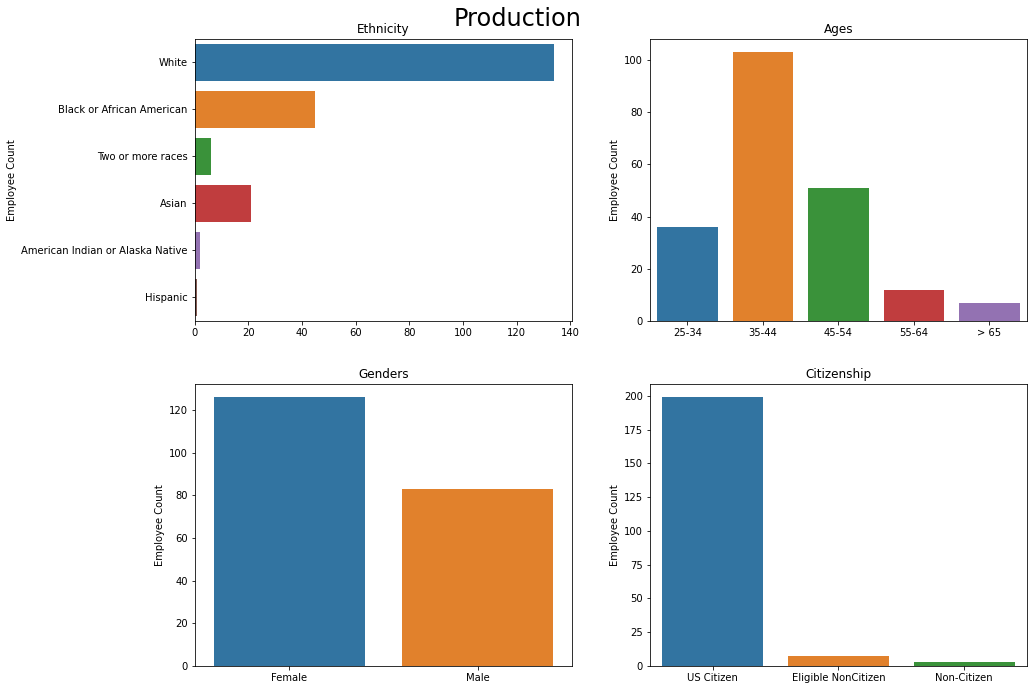

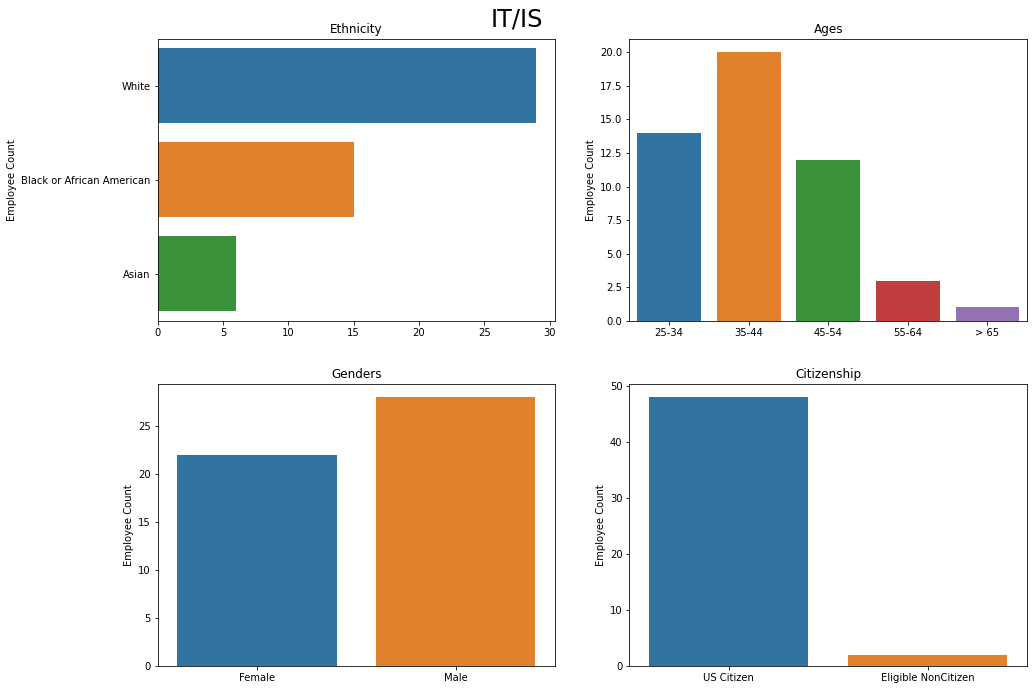

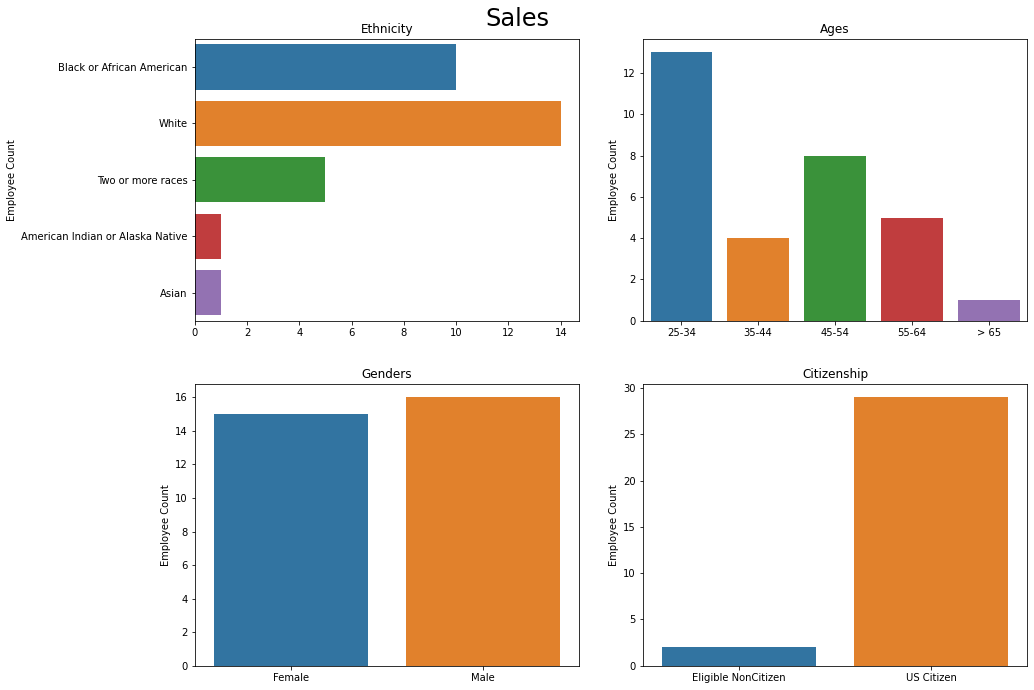

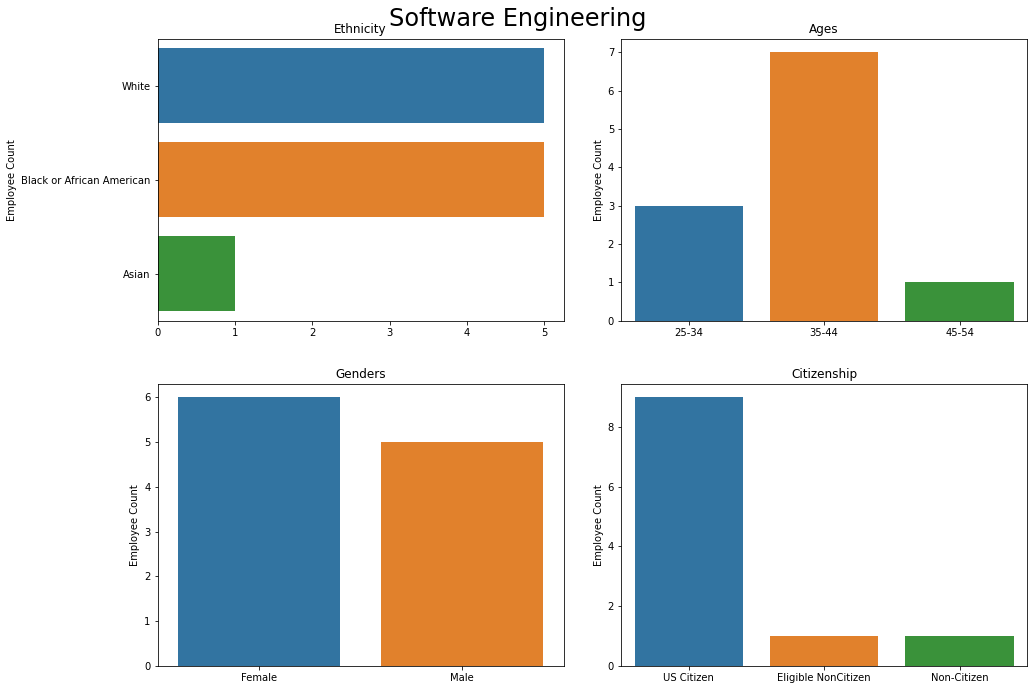

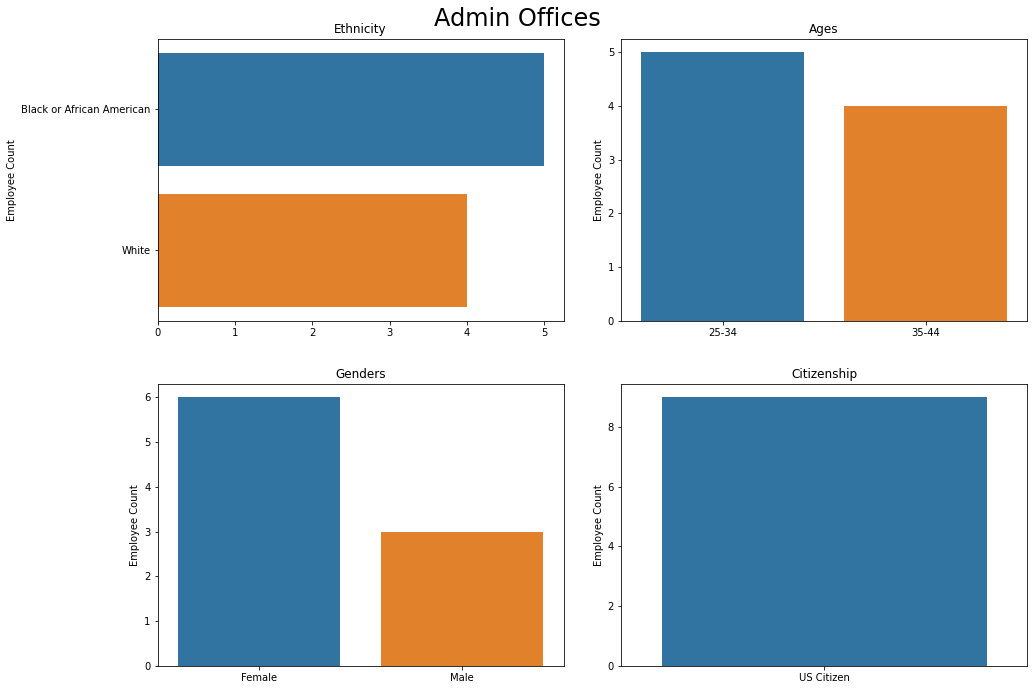

In [ ]:
for count, df in enumerate(df_list):
  Gender = [0, 1]
  Gender_counts = []
  for subcount, gender in enumerate(Gender):
    Gender_counts.append([])
    Gender_counts[subcount]= df[df['GenderID'] == gender].shape[0]

  Races = df.RaceDesc.unique().tolist()
  Races_counts = []
  for subcount, race in enumerate(Races):
    Races_counts.append([])
    Races_counts[subcount]= df[df['RaceDesc'] == race].shape[0]

  Ages = df.Age_group.unique().tolist()
  Ages.sort()
  Ages_counts = []
  for subcount, age_band in enumerate(Ages):
    Ages_counts.append([])
    Ages_counts[subcount]= df[df['Age_group'] == age_band].shape[0]

  Citizenship = df.CitizenDesc.unique().tolist()
  Citizenship_counts = []
  for subcount, citizenship in enumerate(Citizenship):
    Citizenship_counts.append([])
    Citizenship_counts[subcount]= df[df['CitizenDesc'] == citizenship].shape[0]

  figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
  figure.suptitle(departments[count], fontsize = 24)

  sns.barplot(ax = axes[0,0], y = Races, x = Races_counts)
  axes[0,0].set(ylabel = 'Employee Count')
  axes[0,0].set_title('Ethnicity')

  sns.barplot(ax = axes[1,0], x = ['Female', 'Male'], y = Gender_counts)
  axes[1,0].set(ylabel = 'Employee Count')
  axes[1,0].set_title('Genders')

  sns.barplot(ax = axes[0,1], x = Ages, y = Ages_counts)
  axes[0,1].set(ylabel = 'Employee Count')
  axes[0,1].set_title('Ages')

  sns.barplot(ax = axes[1,1], x = Citizenship, y = Citizenship_counts)
  axes[1,1].set(ylabel = 'Employee Count')
  axes[1,1].set_title('Citizenship')

  figure.tight_layout(pad = 3.0)

Add some analysis to the charts for the various departments.